In [1]:
import numpy as np
#from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import basinhopping
#from pandas import Series, DataFrame
#import pandas as pd
import sys
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
#from statsmodels.stats.anova import anova_lm
#get_ipython().magic('matplotlib qt5')
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
%matplotlib qt5

In [2]:
au2eV=27.2113845

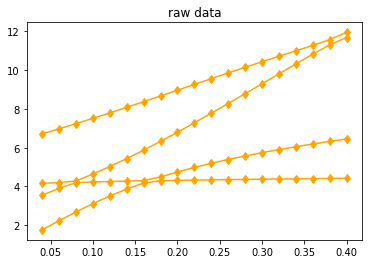

In [3]:
data = np.lib.loadtxt("CO2.dat")
ls = data[:,0]
Es = data[:,1:]
n_ene = np.shape(Es)[1]

plt.cla()
plt.title('raw data')
for i in range(n_ene):
    Es[i,:]=sorted(Es[i,:])
    plt.plot(ls, Es[:,i], marker='d', color='orange')
plt.show() 

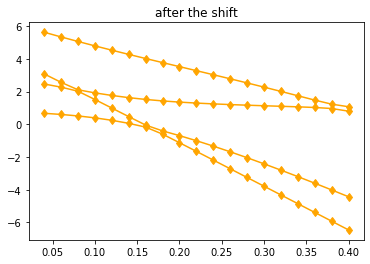

In [4]:
plt.cla()
plt.title('after the shift')
for i in range(n_ene):
    Es[:,i] -= ls * au2eV
    plt.plot(ls, Es[:,i], marker='d', color='orange')
plt.show()

In [5]:
#Orignal 
def pade_21(k, l, a, b):
    """ Pade [2.1]  """
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    return l*(k*k + aak2 + a4b2) / (a4b2 + aak2)
#Reordered
def pade_21_rd(k, a, b, l):
    """ Pade [2.1]  """
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    return l*(k*k + aak2 + a4b2) / (a4b2 + aak2)

#Original
def chi2_21(params, ks, ls):
    """ 
    Pade-III fit, parameter order should not matter in BFGS
    (order matters in older algorithms)
    """
    l = params[0]
    a = params[1]
    b = params[2]
    chi2 = 0
    for i in range(len(ks)):
        chi2 += ((pade_21(ks[i],l,a,b) - ls[i]))**2
    return chi2 / len(ks)
#Reordered
def chi2_21_rd(params, ks, ls):
    """ 
    Pade-III fit, parameter order should not matter in BFGS
    (order matters in older algorithms)
    """
    a = params[0]
    b = params[1]
    l = params[2]
    chi2 = 0
    for i in range(len(ks)):
        chi2 += ((pade_21_rd(ks[i],a,b,l) - ls[i]))**2
    return chi2 / len(ks)

In [6]:
#Original from your old code, doc strings in place
def pade_31(k, l, a, b, d):
    """ 
    Pade [3,1] eq.(9) corrected by missing factor 2 in a^2k terms 
    """
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    ddk=d*d*k
    num = (k*k + aak2 + a4b2) * (1 + ddk)
    den = a4b2 + aak2 + ddk*a4b2
    return l * num / den 
#Reordered
def pade_31_rd( k, a, b, d, l):
    """ 
    Pade [3,1] eq.(9) corrected by missing factor 2 in a^2k terms 
    """
    a4b2=a*a*a*a + b*b
    aak2=a*a*k*2
    ddk=d*d*k
    num = (k*k + aak2 + a4b2) * (1 + ddk)
    den = a4b2 + aak2 + ddk*a4b2
    return l * num / den 

#Original
def chi2_31(params, ks, ls):
    """ 
    Pade-III fit: 
    put the most trusted parameters last, 
    because the 1st parameters may be optimized 1st
    """
    d = params[3]
    l = params[0]
    a = params[1]
    b = params[2]
    chi2 = 0
    for i in range(len(ks)):
        chi2 += ((pade_31(ks[i],l,a,b,d) - ls[i]))**2
    return chi2 / len(ks)
#Reordered
def chi2_31_rd(params, ks, ls):
    """ 
    Pade-III fit: 
    put the most trusted parameters last, 
    because the 1st parameters may be optimized 1st
    """
    a = params[0]
    b = params[1]
    d = params[2]
    l = params[3]
    chi2 = 0
    for i in range(len(ks)):
        chi2 += ((pade_31_rd(ks[i],a,b,d,l) - ls[i]))**2
    return chi2 / len(ks)

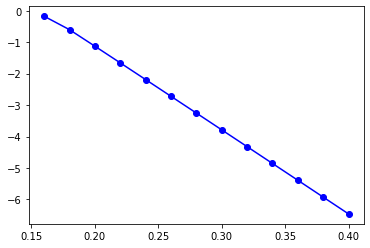

In [7]:
E0=Es[:,0]
e_max = 0.0
e_min = -10.0
i_max = np.argmin(abs(E0-e_max))
i_min = np.argmin(abs(E0-e_min))
if E0[i_max] > e_max:
    i_max += 1
if E0[i_min] < e_min:
    i_min -= 1
Esel = E0[i_max:i_min+1]
lsel = ls[i_max:i_min+1]
plt.plot(lsel, Esel, marker='o', color='blue')

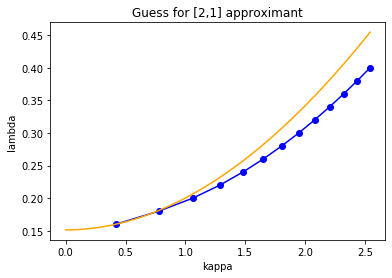

In [14]:
ks = np.sqrt(-Esel)
Er=3.0
G=0.3

# guess:
ag=0.5*np.sqrt(2.0)*(-2*Er + np.sqrt(4*Er**2 + G**2))**0.25
bg=0.5*G/np.sqrt(-2*Er + np.sqrt(4*Er**2 + G**2))
lg=lsel[0]/pade_21(ks[0],1,ag,bg)

plt.cla()
plt.title('Guess for [2,1] approximant')
plt.xlabel('kappa')
plt.ylabel('lambda')
plt.plot(ks, lsel, marker='o', color='blue')
nplt=200
kps=np.linspace(0,ks[-1],nplt)
lps=np.zeros(nplt)
plt.plot(kps, pade_21(kps, lg, ag, bg), marker='', color="orange")
plt.show()

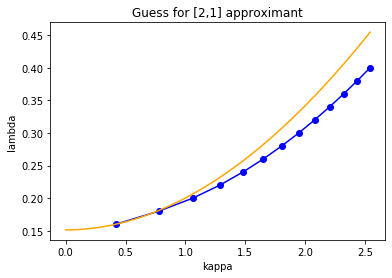

In [15]:
ks = np.sqrt(-Esel)         #The reordered box
Er=3.0
G=0.3

# guess_rd:
ag_rd=0.5*np.sqrt(2.0)*(-2*Er + np.sqrt(4*Er**2 + G**2))**0.25
bg_rd=0.5*G/np.sqrt(-2*Er + np.sqrt(4*Er**2 + G**2))
lg_rd=lsel[0]/pade_21_rd(ks[0],ag,bg,1)

plt.cla()
plt.title('Guess for [2,1] approximant')
plt.xlabel('kappa')
plt.ylabel('lambda')
plt.plot(ks, lsel, marker='o', color='blue')
nplt=200
kps=np.linspace(0,ks[-1],nplt)
lps=np.zeros(nplt)
plt.plot(kps, pade_21_rd(kps, ag_rd, bg_rd, lg_rd), marker='', color="orange")
plt.show()

chi = 1.080368e-06


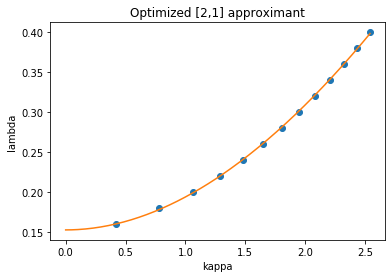

array([0.15271462, 0.31763714, 1.86935908])

In [16]:
p0s=[ lg, ag, bg ]
res = minimize(chi2_21, p0s, method='BFGS', args=(ks,lsel))
print("chi = %e" % res.fun)
lopt=res.x[0]
aopt=res.x[1]
bopt=res.x[2]

plt.cla()
plt.title('Optimized [2,1] approximant')
plt.xlabel('kappa')
plt.ylabel('lambda')
plt.plot(ks, lsel, 'o')
plt.plot(kps, pade_21(kps, lopt, aopt, bopt))
plt.show()
res.x

In [18]:
p0s_rd=[ag_rd, bg_rd, lg_rd ]    #The Reordered Box
res_rd = minimize(chi2_21_rd, p0s_rd, method='BFGS', args=(ks,lsel))
#print("chi = %e" % res_rd.fun)
lopt_rd=res_rd.x[2]
aopt_rd=res_rd.x[0]
bopt_rd=res_rd.x[1]

#plt.cla()
#plt.title('Optimized [2,1] approximant')
#plt.xlabel('kappa')
#plt.ylabel('lambda')
#plt.plot(ks, lsel, 'o')
#plt.plot(kps, pade_21_rd(kps, aopt_rd, bopt_rd, lopt_rd))
#plt.show()


print("chi = %e" % res.fun)
print("chi = %e" % res_rd.fun)
print(res.x[0], res.x[1], res.x[2])
print(res_rd.x[2], res_rd.x[0], res_rd.x[1])

chi = 1.080368e-06
chi = 1.080368e-06
0.15271461628577046 0.3176371406485295 1.8693590778160112
0.15271461628577046 0.3176371406485295 1.8693590778160112


In [19]:
#Guess
dg=0.0
lg=lsel[0]/pade_31(ks[0],1,aopt,bopt,dg)
p0s=[lg, aopt, bopt, dg]
res = minimize(chi2_31, p0s, method='BFGS', args=(ks,lsel))



#Guess Reordered
dg_rd=0.0
lg_rd=lsel[0]/pade_31_rd(ks[0],aopt_rd,bopt_rd,dg_rd,1)
p0s_rd=[aopt_rd,bopt_rd,dg_rd,lg_rd]
res_rd = minimize(chi2_31_rd, p0s_rd, method='BFGS', args=(ks,lsel))

print("chi = %e" % res.fun)
print("chi = %e" % res_rd.fun)
print(res.x[0], res.x[1], res.x[2], res.x[3])
print(res_rd.x[3], res_rd.x[0], res_rd.x[1], res_rd.x[2])

chi = 1.080352e-06
chi = 1.080352e-06
0.15271255552111254 0.3176282453867992 1.8693496990775753 2.4074270354725923e-13
0.15271255552111254 0.3176282453867992 1.8693496990775753 2.4074270354725923e-13
